In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet101
# from tensorflow.keras.applications import Xception
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#It should be 
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from sklearn import preprocessing
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from zipfile import ZipFile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pickle import NONE
from pathlib import Path

from zmq.constants import NULL
X = []
y = []
os.chdir('/content/drive/MyDrive/Spectrogram For Train Test/Deep Breath Cov-Non Cov/Covid')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)   
      img = cv2.resize(img,(224,224))
      X.append(img)
      y.append('c')

os.chdir('/content/drive/MyDrive/Spectrogram For Train Test/Deep Breath Cov-Non Cov/Non Covid')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      if(type(img) == type(None)):
        pass
      else:
        img = cv2.resize(img,(224,224))
        X.append(img)
        y.append('n')

from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy={'c': 500},random_state=42)
X = np.array(X)
X_resampled, y_resampled = sm.fit_resample(X.reshape(X.shape[0], -1), np.array(y))
X_resampled = X_resampled.reshape(-1, 224, 224, 3)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)
print(y)
print(X_resampled.shape)

100%|██████████| 1343/1343 [00:48<00:00, 27.70it/s]


['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n',

In [4]:

print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test) 

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [7]:
BATCH_SIZE =20
EPOCHS = 100
SIZE = 224
N_ch=3

In [8]:
def build_resnet101():
    resnet101 = ResNet101(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet101(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [9]:
model = build_resnet101()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('ResNet101_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

171446536/171446536 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 resnet101 (Functional)      (None, None, None, 2048)  42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
X_train.shape[0]
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=10,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, y_test))

<ipython-input-10-c4089a8f5804>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.2013 - accuracy: 0.5500
Epoch 1: val_loss improved from inf to 0.51002, saving model to ResNet101_Model.hdf5
10/10 [==============================] - 37s 2s/step - loss: 1.2013 - accuracy: 0.5500 - val_loss: 0.5100 - val_accuracy: 0.7826 - lr: 5.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 1.1047 - accuracy: 0.5208
Epoch 2: val_loss improved from 0.51002 to 0.48056, saving model to ResNet101_Model.hdf5
10/10 [==============================] - 10s 1s/step - loss: 1.1047 - accuracy: 0.5208 - val_loss: 0.4806 - val_accuracy: 0.8071 - lr: 5.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.9487 - accuracy: 0.5833
Epoch 3: val_loss did not improve from 0.48056
10/10 [==============================] - 6s 561ms/step - loss: 0.9487 - accuracy: 0.5833 - val_loss: 0.4902 - val_accuracy: 0.8723 - lr: 5.0000e-04
Epoch 4/100
10/10 [==============================] - E

In [16]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



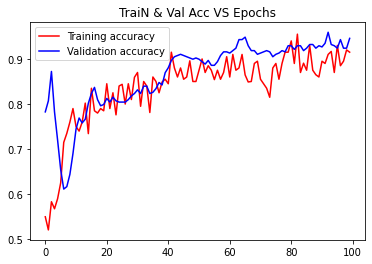

<Figure size 432x288 with 0 Axes>

In [17]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()



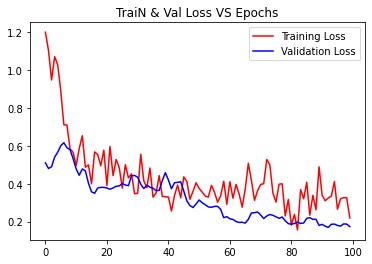

<Figure size 432x288 with 0 Axes>

In [18]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [19]:
model.load_weights("ResNet101_Model.hdf5")
model.save("/content/drive/MyDrive/Model Saves/Resnet101 Deep Breath")
score = model.evaluate(X_test,y_test ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

12/12 [==============================] - 2s 150ms/step - loss: 0.1690 - accuracy: 0.9592
Test Loss: 0.1689741611480713
Test accuracy: 95.923912525177


In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np

pred = model.predict(X_test)
rounded_labels_1 = np.argmax(pred, axis=1)
rounded_labels_2 = np.argmax(y_test, axis=1)
rounded_labels_1[1]
rounded_labels_2[1]
print(accuracy_score(rounded_labels_2,rounded_labels_1))
print(confusion_matrix(rounded_labels_2,rounded_labels_1))
print(classification_report(rounded_labels_2,rounded_labels_1,zero_division=1))

12/12 [==============================] - 2s 152ms/step
0.9592391304347826
[[ 79   9]
 [  6 274]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        88
           1       0.97      0.98      0.97       280

    accuracy                           0.96       368
   macro avg       0.95      0.94      0.94       368
weighted avg       0.96      0.96      0.96       368



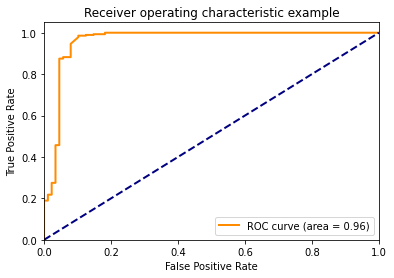

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(rounded_labels_2, pred[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, pred)
print("AUC: ", roc_auc)

AUC:  0.9617288961038961
